In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns # For enhanced visualisatons


#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#  Change File Path to use on main data file.
file_path = 'csv\cleaned_csv\pp-complete_cleaned_data.csv' 
#  Change File Path to use on main data file.
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


# Import csv into df, remove the header as it's actually a row of data, set column names & add an index.
df = pd.read_csv(file_path, index_col=0)

# clean date time
df['date_of_transfer'] = pd.to_datetime(df['date_of_transfer'], errors='coerce') # turn date into datetime value

In [12]:
# Remove Gatwick from Data as its all commercial property (airport hotels) & Filtering out Thornhill as it looks like just one farm sale, commercial again:
df = df[(df['town_city'] != 'GATWICK') & (df['town_city'] != 'THORNHILL')]

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
# This removes the lowest 1% & the Highest 1% to prevent scewed data.
lower_limit, upper_limit = df['price'].quantile([0.01, 0.99])  
df = df[(df['price'] >= lower_limit) & (df['price'] <= upper_limit)]
# Consider removing when not doing test and using full df
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [13]:
df_o1 = df.copy()

In [14]:

average_type = 'mean'
df_o1['town_city_avg_price'] = df_o1.groupby('town_city')['price'].transform(average_type)

In [15]:

df_top_10 = df_o1.groupby('town_city')['price'].mean().reset_index()


df_top_10 = df_top_10.sort_values(by='price', ascending=False).head(10)


In [16]:
town_county = df_o1[['town_city', 'county']].drop_duplicates()

In [17]:
town_county['joined_col'] = town_county['town_city'] + ', ' + town_county['county']
df_top_10 = df_top_10.merge(town_county, on='town_city', how='left')

top_10_dict = dict(zip(df_top_10.iloc[:, 0], df_top_10.iloc[:, 2]))

top_10_dict

ylabels = [f"{town}, {county}" for town, county in top_10_dict.items()]

ylabels

['CHALFONT ST GILES, BUCKINGHAMSHIRE',
 'BEACONSFIELD, MILTON KEYNES',
 'KESTON, GREATER LONDON',
 'GERRARDS CROSS, MILTON KEYNES',
 'ESHER, SURREY',
 'COBHAM, SURREY',
 'VIRGINIA WATER, SURREY',
 'ST ALBANS, CENTRAL BEDFORDSHIRE',
 'BROCKENHURST, HAMPSHIRE',
 'WELWYN, HERTFORDSHIRE']

In [18]:
# set df of most expensive town for further analysis
expensive_town = df_top_10['town_city'][0]
df_exp_town = df_o1[df_o1['town_city'] == expensive_town]
# change expensive town to full joined name for labelling purposes
expensive_town = df_top_10['joined_col'][0] 




##### Data Labels would definately enhance these visualisations

C:\Users\Henry\AppData\Local\Temp\ipykernel_12032\3072192853.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


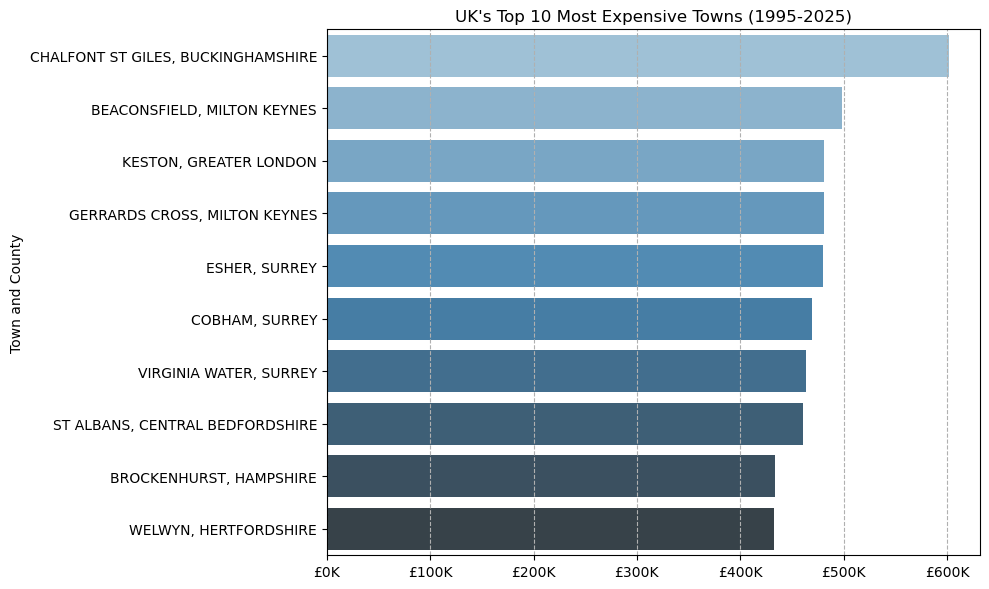

In [31]:
fig, ax = plt.subplots(figsize=(10,6))



sns.barplot(data=df_top_10, x='price', y='town_city', hue='town_city', palette='Blues_d', ax=ax)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'£{int(x/1000)}K'))
ax.set_yticklabels(ylabels)
plt.ylabel('Town and County')
plt.xlabel('')
plt.title("UK's Top 10 Most Expensive Towns (1995-2025)")
plt.grid(axis= 'x', linestyle = '--')
plt.tight_layout()
plt.show()

## Dig a little bit deeper into the price history of the UKs most expensive town

In [ ]:
average_type = 'mean'
df_exp_town.loc[:, 'year_of_transfer'] = df_exp_town['date_of_transfer'].dt.year # add a column with just the year for agg purposes. dt.year gives me an int. dt.strftime('%Y') gives a string
df_exp_town['year_avg_sale'] = df_exp_town.groupby('year_of_transfer')['price'].transform(average_type)

average_type = average_type.capitalize() # for the title of the graph

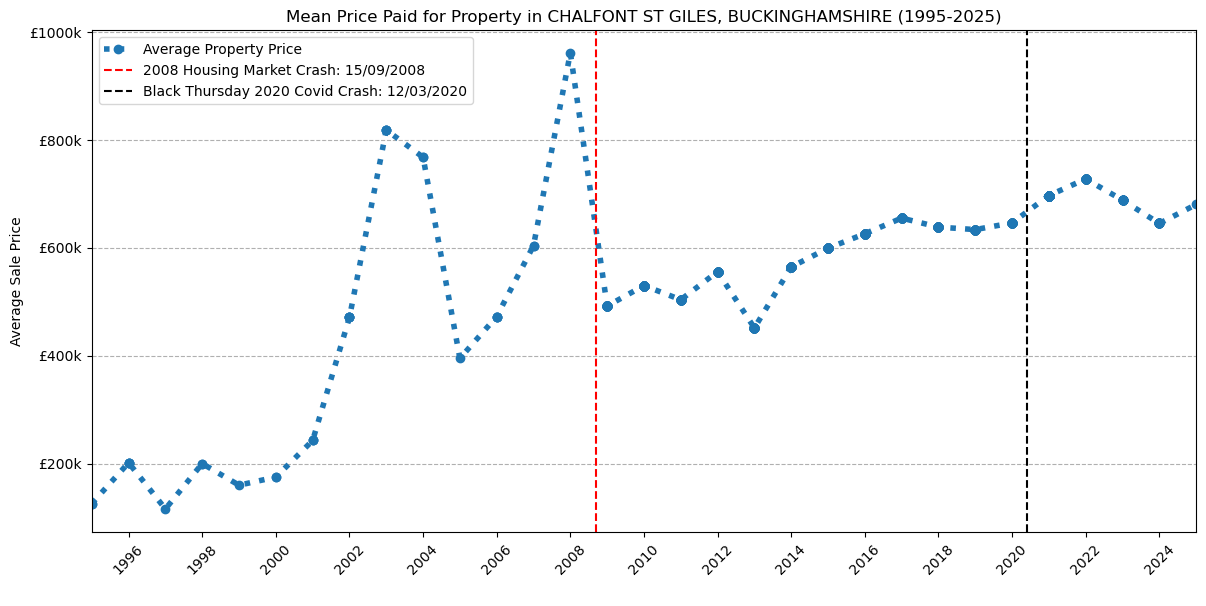

In [32]:
fig, ax = plt.subplots()

df_exp_town.plot(
    kind='line',
    linewidth=4, 
    linestyle=':',
    marker='o',
    markersize=6,
    x='year_of_transfer', 
    y='year_avg_sale', 
    label="Average Property Price",
    figsize=(12,6), 
    ax=ax)

house_crash_date = pd.to_datetime('2008-09-15') # 2008 great reccession started on 15/09/2008
covid_crash_date = pd.to_datetime('2020-03-12') # black thursday covid 19 market crash

house_crash_line = ax.axvline(house_crash_date.year + 0.7, color='red', linestyle='--', linewidth=1.5)
covid_line = ax.axvline(covid_crash_date.year + 0.393, color='black', linestyle='--', linewidth=1.5)
house_line = ax.get_lines()[0]

house_crash_date = pd.to_datetime('2008-09-15') # 2008 great reccession started on 15/09/2008
covid_crash_date = pd.to_datetime('2020-03-12') # black thursday covid 19 market crash

ax.legend(
    [house_line, house_crash_line, covid_line],
    ['Average Property Price', f'2008 Housing Market Crash: 15/09/2008', f'Black Thursday 2020 Covid Crash: 12/03/2020'],
    loc='upper left'
)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'£{int(y/1000)}k')) # Formats the Y ticks to £100k etc
plt.locator_params(axis='x', nbins=19) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle="--") #Grid & linestyle of grid.
plt.xlim(1995, 2025)
plt.xlabel('   ')
plt.ylabel('Average Sale Price')
plt.title(f'{average_type} Price Paid for Property in {expensive_town} (1995-2025)')

plt.show()

### Now lets take a look at the volume of the UK's most expensive town:

In [22]:
df_exp_town_pivot =df_exp_town.pivot_table(
    values='price',
    index='year_of_transfer',
    aggfunc='count'
    )
df_exp_town_pivot = df_exp_town_pivot.rename(columns={'price': 'Volume'})

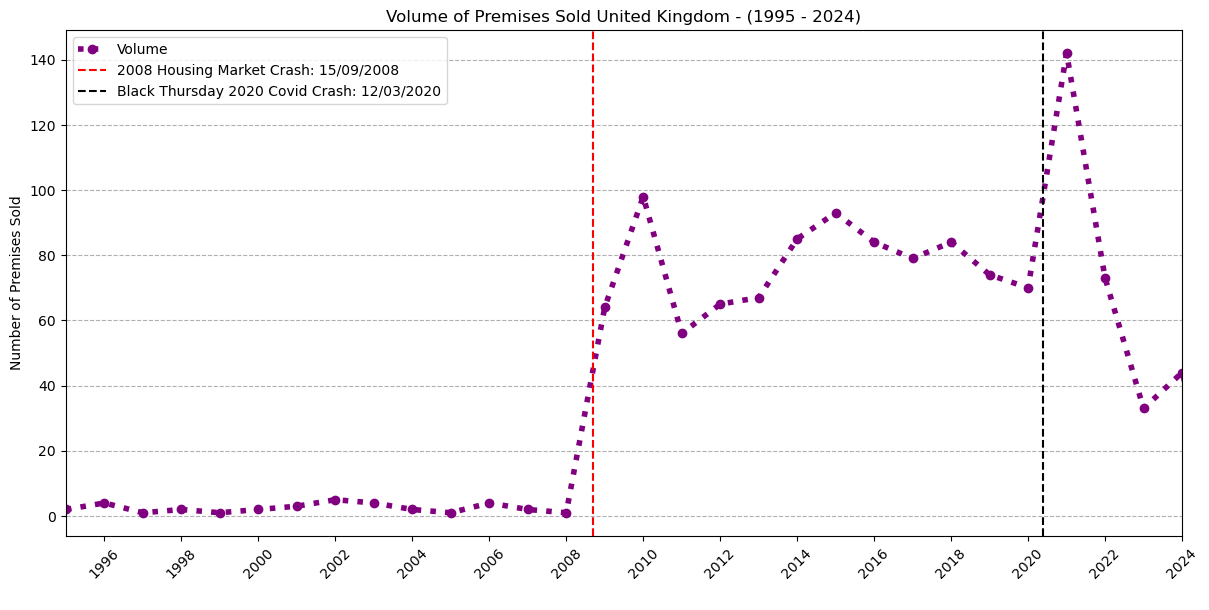

In [33]:
fig, ax = plt.subplots()

df_exp_town_pivot.plot(
    kind='line',
    linewidth=4, 
    linestyle=':',
    color='purple',
    marker='o',
    markersize=6,
    label='Volume',
    figsize=(12,6), 
    ax=ax)

house_crash_line = ax.axvline(house_crash_date.year + 0.7, color='red', linestyle='--', linewidth=1.5)
covid_line = ax.axvline(covid_crash_date.year + 0.393, color='black', linestyle='--', linewidth=1.5)
volume_line = ax.get_lines()[0]

house_crash_date = pd.to_datetime('2008-09-15') # 2008 great reccession started on 15/09/2008
covid_crash_date = pd.to_datetime('2020-03-12') # black thursday covid 19 market crash

ax.legend(
    [volume_line, house_crash_line, covid_line],
    ['Volume', f'2008 Housing Market Crash: 15/09/2008', f'Black Thursday 2020 Covid Crash: 12/03/2020'],
    loc='upper left'
)

plt.locator_params(axis='x', nbins=19) 
plt.xticks(rotation=45)
plt.xlim(1995, 2024)
plt.tight_layout()
plt.grid(axis='y', linestyle="--") #Grid & linestyle of grid.
plt.ylabel('Number of Premises Sold')
plt.title('Volume of Premises Sold United Kingdom - (1995 - 2024)')
plt.xlabel("    ")

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Uncomment if required.
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y/1000)}k')) 
# Uncomment if required.
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


plt.show()

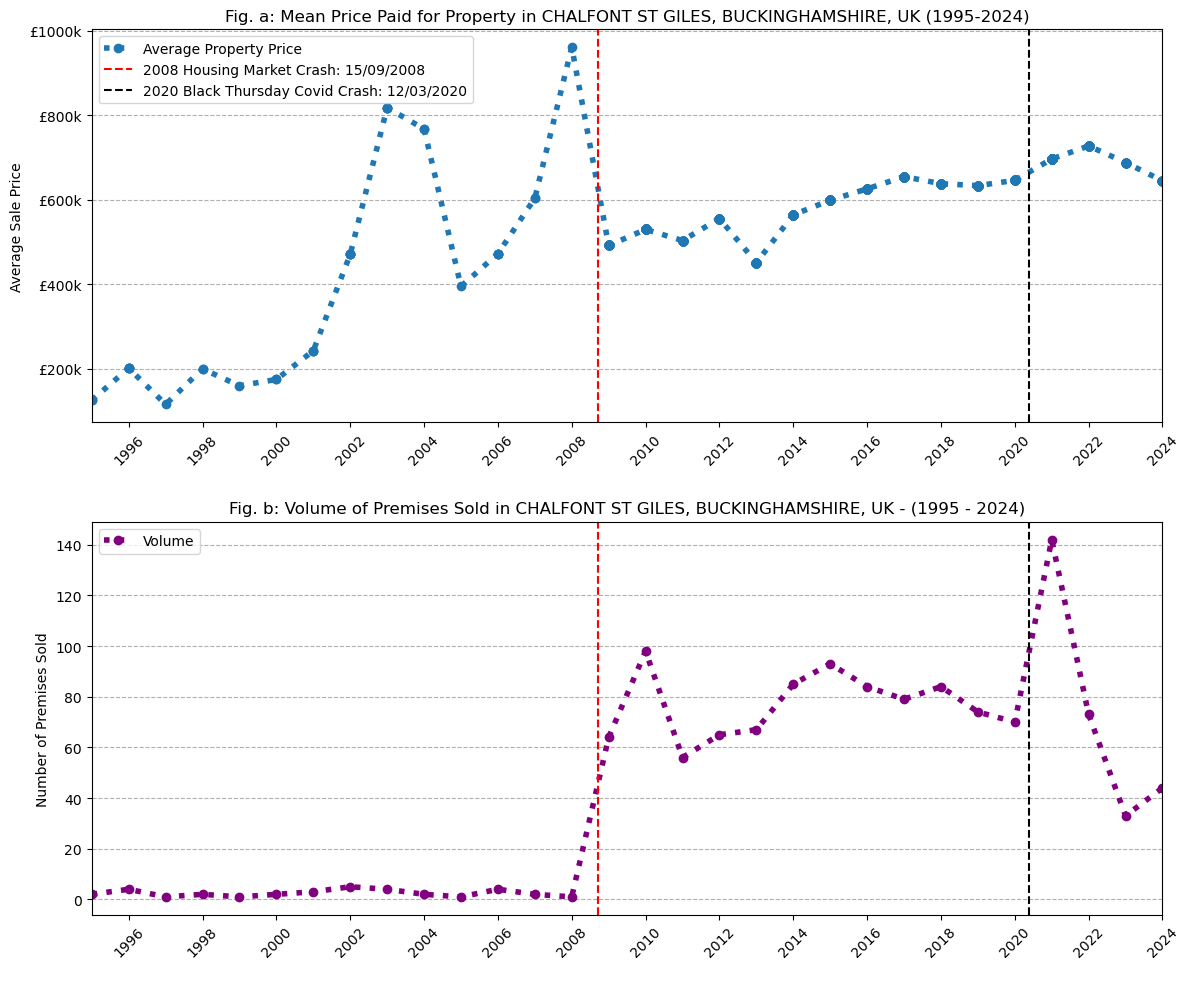

In [35]:
fig, ax = plt.subplots(2,1, figsize=(12,10))

df_exp_town.plot(
    kind='line',
    linewidth=4, 
    linestyle=':',
    marker='o',
    markersize=6,
    x='year_of_transfer', 
    y='year_avg_sale', 
    label="Average Property Price", 
    ax=ax[0])

house_crash_line = ax[0].axvline(house_crash_date.year + 0.7, color='red', linestyle='--', linewidth=1.5)
covid_line = ax[0].axvline(covid_crash_date.year + 0.393, color='black', linestyle='--', linewidth=1.5)
house_line = ax[0].get_lines()[0]

house_crash_date = pd.to_datetime('2008-09-15') # 2008 great reccession started on 15/09/2008
covid_crash_date = pd.to_datetime('2020-03-12') # black thursday covid 19 market crash

ax[0].legend(
    [house_line, house_crash_line, covid_line],
    ['Average Property Price', f'2008 Housing Market Crash: 15/09/2008', f'2020 Black Thursday Covid Crash: 12/03/2020'],
    loc='upper left'
)



ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'£{int(y/1000)}k')) # Formats the Y ticks to £100k etc
ax[0].locator_params(axis='x', nbins=19) 
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(axis='y', linestyle="--") #Grid & linestyle of grid.
ax[0].set_xlim(1995, 2024)
ax[0].set_xlabel('   ')
ax[0].set_ylabel('Average Sale Price')
ax[0].set_title(f'Fig. a: {average_type} Price Paid for Property in {expensive_town}, UK (1995-2024)')

df_exp_town_pivot.plot(
    kind='line',
    linewidth=4, 
    linestyle=':',
    color='purple',
    marker='o',
    markersize=6,
    label='Volume', 
    ax=ax[1])

house_crash_line = ax[1].axvline(house_crash_date.year + 0.7, color='red', linestyle='--', linewidth=1.5)
covid_line = ax[1].axvline(covid_crash_date.year + 0.393, color='black', linestyle='--', linewidth=1.5)
house_line = ax[1].get_lines()[1]



ax[1].locator_params(axis='x', nbins=19) 
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlim(1995, 2024)
ax[1].grid(axis='y', linestyle="--") #Grid & linestyle of grid.
ax[1].set_ylabel('Number of Premises Sold')
ax[1].set_title(f'Fig. b: Volume of Premises Sold in {expensive_town}, UK - (1995 - 2024)')
ax[1].set_xlabel("    ")
ax[1].legend(title='', loc='upper left')


#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Uncomment if required.
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y/1000)}k')) 
# Uncomment if required.
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

fig.tight_layout()
plt.show()